In [13]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [14]:
df_test = pd.read_csv("./training_data/merged_train_i1_f.csv", sep=';')

not_chosen_columns = ['ID', 'Tweet']
label_columns = [col for col in df_test.columns if col not in not_chosen_columns]

df_labels_test = df_test[label_columns]

list_labels_test = df_labels_test.values.tolist()

test_texts = df_test['Tweet'].tolist()
test_labels = list_labels_test

tokenizer = BertTokenizer.from_pretrained("saved_model_i1_f")
model = BertForSequenceClassification.from_pretrained("saved_model_i1_f")

In [15]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

all_probabilities = []

# Process each text
for text in test_texts:
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = torch.sigmoid(logits)  # Apply sigmoid to convert logits to probabilities
    probabilities = probabilities.squeeze(0)

    all_probabilities.append(probabilities) #Değiştir

In [16]:
all_probabilities_l = []

for item in all_probabilities:
    all_probabilities_l.append(item.tolist())

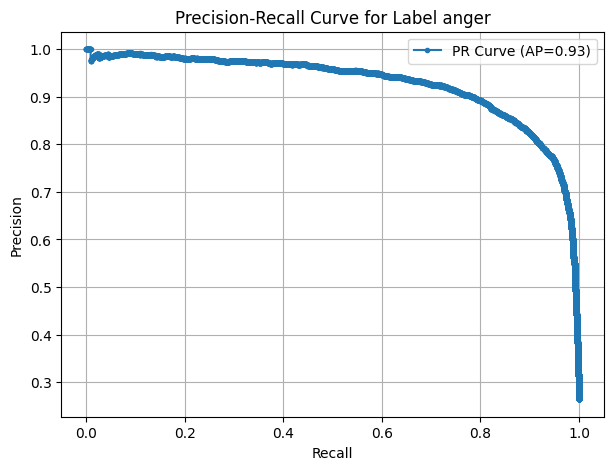

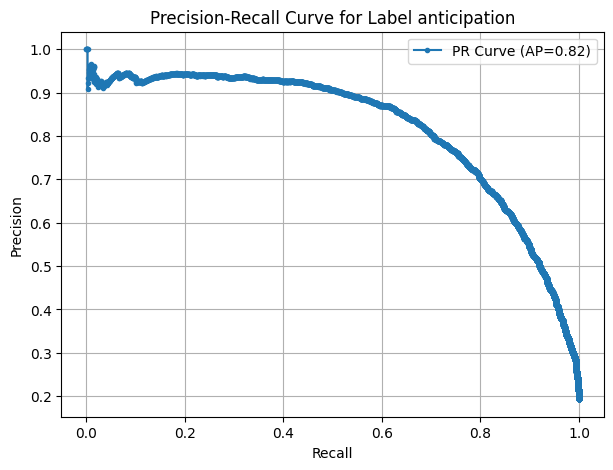

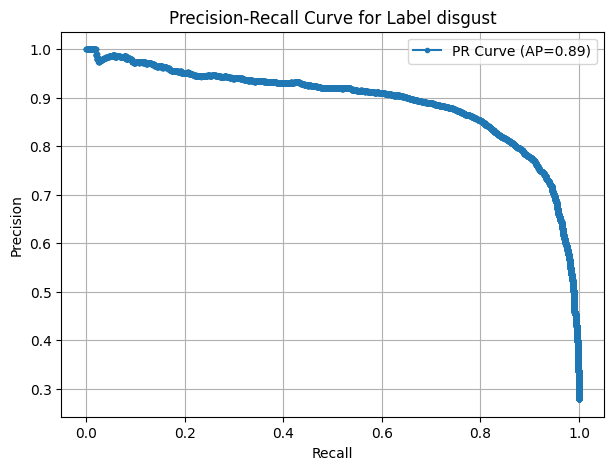

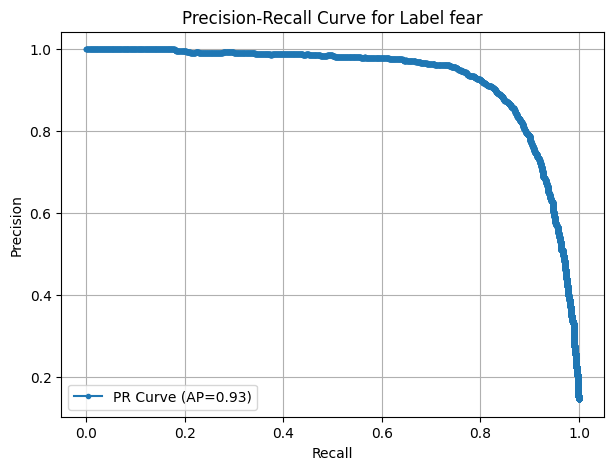

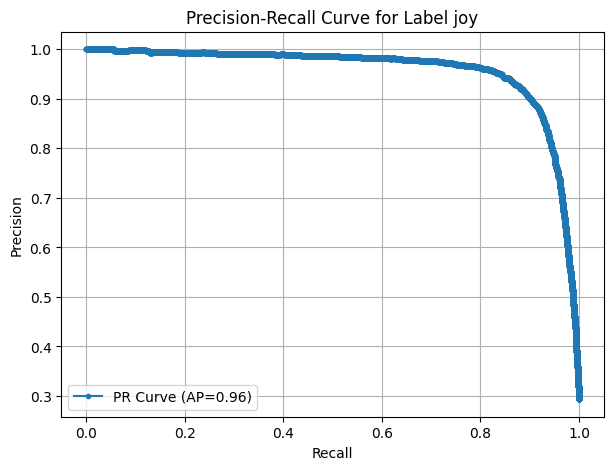

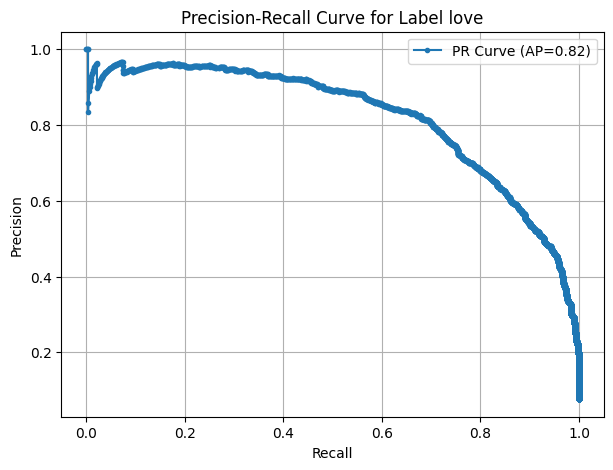

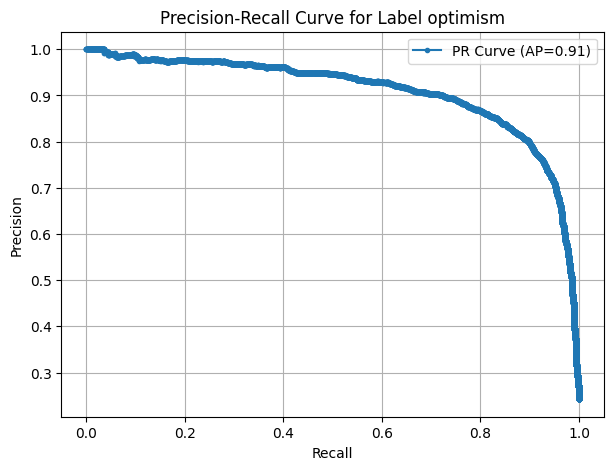

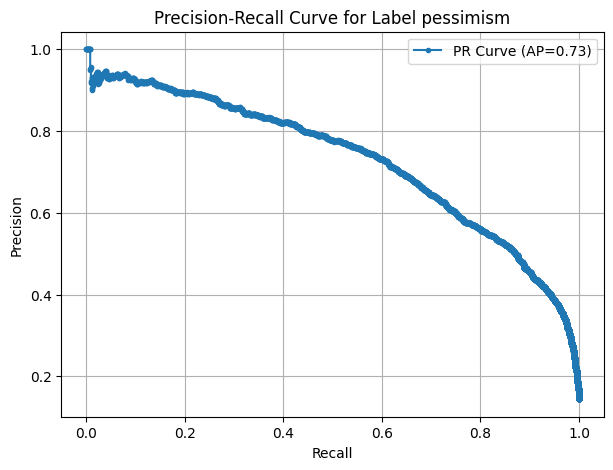

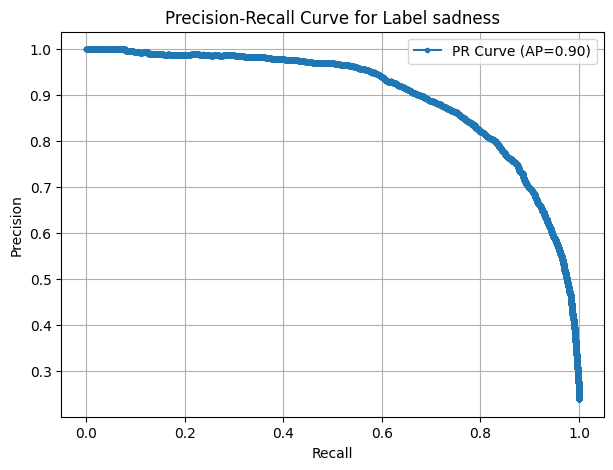

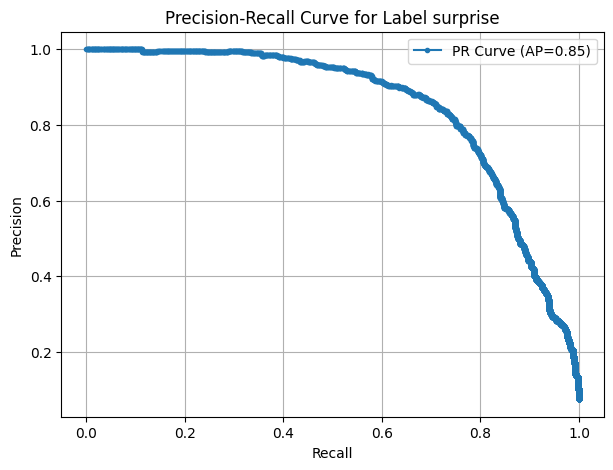

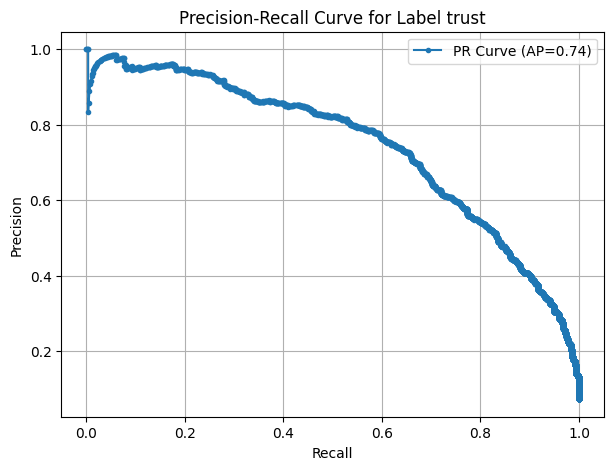

[0.41, 0.37, 0.36, 0.48, 0.47, 0.62, 0.39, 0.49, 0.37, 0.47, 0.56]


,0,1,2,3,4,5,6,7,8,9,10
0,0.034859,0.295769,0.023153,0.206297,0.413735,0.132762,0.984244,0.082353,0.047338,0.055412,0.846142
1,0.021026,0.076437,0.013725,0.019640,0.909799,0.481562,0.948580,0.015838,0.023694,0.037327,0.449607
2,0.633577,0.197258,0.673703,0.029493,0.413171,0.045402,0.111233,0.073902,0.220668,0.761591,0.054026
3,0.018786,0.208907,0.013084,0.037578,0.954137,0.501455,0.973270,0.025117,0.030529,0.101656,0.640664
4,0.930373,0.036231,0.944751,0.133431,0.023135,0.011125,0.013411,0.103777,0.273445,0.037598,0.010681
...,...,...,...,...,...,...,...,...,...,...,...
15248,0.026876,0.145607,0.052560,0.927544,0.060038,0.015793,0.042609,0.101043,0.077859,0.050919,0.022378
15249,0.081954,0.049524,0.177331,0.894390,0.025328,0.011113,0.016714,0.103301,0.123814,0.033859,0.010402
15250,0.061199,0.027229,0.129115,0.057284,0.035515,0.033311,0.041788,0.794157,0.966120,0.024211,0.018210
15251,0.832259,0.027169,0.481036,0.024293,0.057060,0.023848,0.058317,0.025931,0.027666,0.016761,0.030072


In [17]:
#Precision-Recall curve 

from sklearn.metrics import precision_recall_curve, average_precision_score

def optimize_threshold_pr(y_true, y_prob):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)  # Avoid division by zero
    best_threshold = thresholds[np.argmax(f1_scores)]

    return best_threshold

all_probabilities_pd = pd.DataFrame(all_probabilities_l)
test_labels_pd = pd.DataFrame(test_labels)

found_thres = []

for i in range( all_probabilities_pd.shape[1] ):

    col_prob = all_probabilities_pd.iloc[:,i]
    col_prob= torch.tensor(col_prob)

    col_true = test_labels_pd.iloc[:,i]
    col_true= torch.tensor(col_true)

    best_thresh = optimize_threshold_pr(col_true, col_prob)

    precisions, recalls, thresholds = precision_recall_curve(col_true, col_prob)
    ap_score = average_precision_score(col_true, col_prob)

    emotions = ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise", "trust"]

    plt.figure(figsize=(7, 5))
    plt.plot(recalls, precisions, marker=".", label=f"PR Curve (AP={ap_score:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve for Label {emotions[i]}")
    plt.legend()
    plt.grid()
    plt.show()
    
    found_thres.append(round(best_thresh, 2))

print(found_thres)

all_probabilities_pd